In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Flatten, BatchNormalization, MaxPool1D, Activation
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def custom_model(dropout):
    inputs = Input(shape=(101,4))
    x = Conv1D(filters=128, kernel_size=32, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=128, kernel_size=32, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=64, kernel_size=32, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x2 = Flatten()(x)
    
    x = Dropout(dropout)(x)
    
    x = MaxPool1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=32, kernel_size=16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=32, kernel_size=16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=32, kernel_size=16, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    
    x = Flatten()(x)
    
    output2 = Dense(303, activation='sigmoid', name='structure_output')(x2)
    
    d1 = Dense(16, activation='relu')(x) 
    output1 = Dense(1, activation='sigmoid', name='editing_output')(d1)
    
    model = tf.keras.Model(inputs=inputs, outputs=[output1, output2], name="seq->struct&edit")
    
    optimizer = tf.keras.optimizers.RMSprop(decay=0.0005)
    model.compile(loss=[tf.keras.losses.MSE(), tf.keras.losses.CosineSimilarity()], optimizer=optimizer, metrics=['cosine_similarity', 'mse', correlation_coefficient_loss, pearson_r])
    return model 

In [ ]:
#model = build_conv_model(101, 4, 64, 15, [16], blocks=2, dil_rate=1, pooling_size=1, dropout=0.1)
#model = custom_model(0.3)
import numpy
from src.models.conv_model import build_model as build_conv_model
import tensorflow as tf
from src.evaluator.evaluator import Evaluator
from src.models.conv_model import correlation_coefficient_loss, pearson_r
import math
dependencies = {
    'correlation_coefficient_loss': correlation_coefficient_loss,
    'pearson_r': pearson_r
}
def cosJump(epoch): # https://arxiv.org/pdf/1608.03983.pdf
    max_lrate = -3.6
    min_lrate = -6
    t_s = 10
    epoch = epoch%10
    lrate = min_lrate + 0.5*(max_lrate-min_lrate)*(1+math.cos(epoch*1.0/t_s * math.pi))
    return math.pow(10, lrate)

lrate = tf.keras.callbacks.LearningRateScheduler(cosJump, verbose=1)
optimizer = tf.keras.optimizers.RMSprop(lr=3e-5)

#model = custom_model(0.3)
#print(model.summary())

In [ ]:
from src.data_loader.SeqToStructEdit import SeqToStructEditGen 
train_generator = SeqToStructEditGen("data/processed/cDNA-ABE/train_data.hdf5", 256)
validation_generator = SeqToStructEditGen("data/processed/cDNA-ABE/validation_data.hdf5", 256)

In [ ]:
import tensorflow as tf
from time import time

checkpoint_filepath = "models/cDNA-ABE/12.16.20/model-{epoch:02d}-{val_editing_output_pearson_r:.4f}.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    #monitor='val_pearson_r',
    #mode='max',
    save_best_only=False)

from tensorflow import keras
model = keras.models.load_model('models/cDNA-ABE/export/Seq->Struct+Edit.4987.h5', custom_objects= dependencies)
print(model.summary())
model.compile(loss='mse', optimizer=optimizer, metrics=['cosine_similarity', 'mse', correlation_coefficient_loss, pearson_r])
history = model.fit(x=train_generator, epochs=30, validation_data=validation_generator, callbacks=[model_checkpoint_callback, lrate], use_multiprocessing=True, workers=40)

In [1]:
import numpy
from src.models.conv_model import build_model as build_conv_model
import tensorflow as tf
from src.evaluator.evaluator import Evaluator
from src.models.conv_model import correlation_coefficient_loss, pearson_r

dependencies = {
    'correlation_coefficient_loss': correlation_coefficient_loss,
    'pearson_r': pearson_r
}

from tensorflow import keras
model = keras.models.load_model('models/cDNA-ABE/export/Seq->Struct+Edit.4987.h5', custom_objects= dependencies)
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.


Model: "seq->struct&edit"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 101, 128)     16512       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 101, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 101, 128)     0           batch_normalization[0][0]        
___________________________________________________________________________________

In [2]:
from src.data_loader.SeqToStructEdit import SeqToStructEditGen 
test_generator = SeqToStructEditGen("data/processed/cDNA-ABE/test_data.hdf5", 512)

In [3]:
preds = model.predict(test_generator, workers = 20, use_multiprocessing=True)

In [4]:
from tqdm import tqdm
gt = list()
gt2 = list()
for x in tqdm(test_generator):
    gt.append(x[1][0])
    gt2.append(x[1][1])

100%|██████████| 476/476 [07:08<00:00,  1.11it/s]


In [5]:
import numpy as np
edit_ground_truth = np.concatenate(gt)
struct_ground_truth = np.concatenate(gt2)

In [6]:
edit_preds = preds[0]
struct_preds = preds[1]

In [7]:
#Compute cosine similarity distribution for predicted and ground-truth data
from tqdm import trange

def cosine_sim(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

cosine_similarities = np.empty((struct_preds.shape[0],1))
for x in trange(len(struct_preds)):
    cosine_similarities[x] = cosine_sim(struct_preds[x].flatten(), struct_ground_truth[x].flatten())


100%|██████████| 243712/243712 [00:03<00:00, 61148.80it/s]


Text(0.5, 1.0, 'Cosine Similarity between Observed and Predicted Structure')

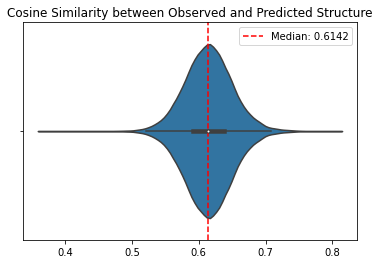

In [10]:
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

data = pd.DataFrame(data=cosine_similarities)
data.columns = ['sim']

p = sns.violinplot(cosine_similarities)
median = np.median(cosine_similarities)
plt.axvline(median,color='r', linestyle='--')
line = Line2D([0,1],[0,1],linestyle='--', color='r')
plt.legend([line],['Median: {0:.4f}'.format(median, "4f")])
plt.title("Cosine Similarity between Observed and Predicted Structure")


In [15]:
edit_ground_truth = edit_ground_truth.reshape(edit_ground_truth.shape[0], 1)

In [19]:
res = np.hstack((edit_ground_truth, edit_preds))
import pandas as pd
df = pd.DataFrame(data=res)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/opt/miniconda3/envs/tf1.15.2/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


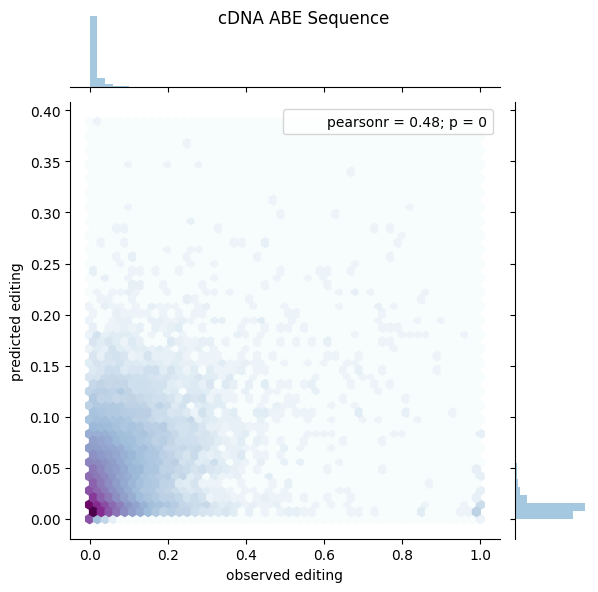

In [21]:
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt
df.columns = ['observed editing', 'predicted editing']
p = sns.jointplot(data=df, x="observed editing", y="predicted editing", kind="hex", bins='log',  cmap='BuPu')
p.annotate(stats.pearsonr)
p.fig.suptitle("cDNA ABE Sequence")
plt.show()

In [31]:
from src.data_loader.RNASeqLoader import RNASeqDataGenerator
o_generator = RNASeqDataGenerator("data/processed/genomic_alignment/test_data.hdf5", 512)

In [32]:
o_generator[300][1].shape

(1024,)

In [33]:
from tqdm import tqdm
ga_edits = list()
for x in tqdm(o_generator):
    ga_edits.append(x[1])
ga_edits = np.concatenate(ga_edits)

100%|██████████| 325/325 [02:55<00:00,  1.85it/s]


In [40]:
ga_edits = ga_edits.reshape(ga_edits.shape[0], 1)
edit_ground_truth = edit_ground_truth.reshape(edit_ground_truth.shape[0], 1)


IndexError: single positional indexer is out-of-bounds

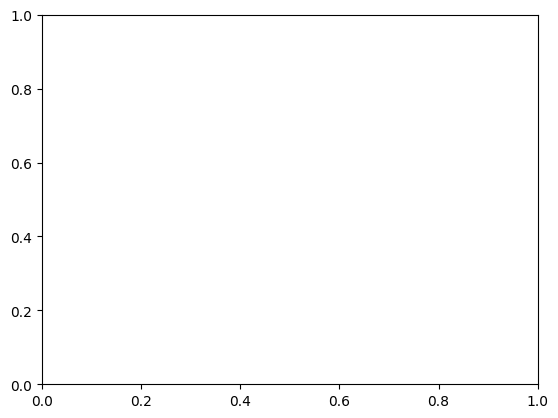

In [54]:
#p = sns.distplot(ga_edits)
df = pd.DataFrame(data=ga_edits)
df.columns = ['ga editing']
p = sns.kdeplot(data=df, x="ga editing", log_scale=True)

Text(0.5, 1.0, 'Cosine Similarity between Observed and Predicted Structure')

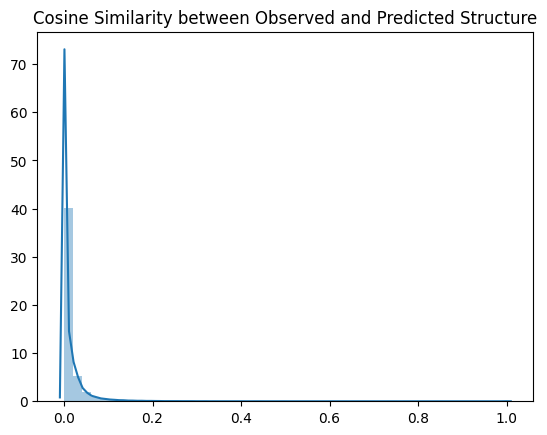

In [56]:
p = sns.distplot(edit_ground_truth)
p.xlim=(0.1,1)
#median = np.median(cosine_similarities)
#plt.axvline(median,color='r', linestyle='--')
#line = Line2D([0,1],[0,1],linestyle='--', color='r')
#plt.legend([line],['Median: {0:.4f}'.format(median, "4f")])
plt.title("Cosine Similarity between Observed and Predicted Structure")

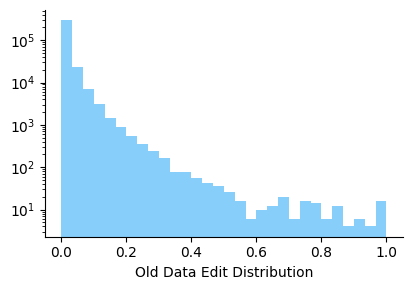

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(ga_edits, columns=['Old Data Edit Distribution']) 

g = sns.FacetGrid(df, aspect=1.5)
g.map(plt.hist, "Old Data Edit Distribution", bins=30, color="lightskyblue")
g.ax.set_yscale('log')

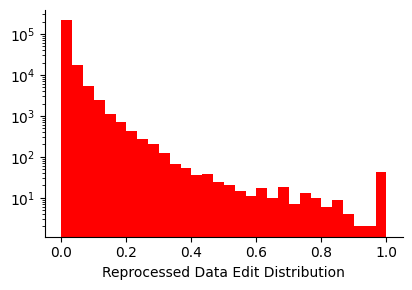

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(edit_ground_truth, columns=['Reprocessed Data Edit Distribution']) 

g = sns.FacetGrid(df, aspect=1.5)
g.map(plt.hist, 'Reprocessed Data Edit Distribution', bins = 30, color="r")
g.ax.set_yscale('log')